# Dask bag

Dask proposes "big data" collections with a small set of high-level primitives like `map`, `filter`, `groupby`, and `join`.  With these common patterns we can often handle computations that are more complex than map, but are still structured.

- Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs ("messy" data)
- When you encounter a set of data with a format that does not enforce strict structure and datatypes.

**Related Documentation**

*  [Bag Documenation](http://dask.pydata.org/en/latest/bag.html)
*  [Bag API](http://dask.pydata.org/en/latest/bag-api.html)

In [1]:
data = list(range(1,9))
data

[1, 2, 3, 4, 5, 6, 7, 8]

In [2]:
import dask.bag as db

b = db.from_sequence(data)

In [3]:
b.compute()  # Gather results back to local process

[1, 2, 3, 4, 5, 6, 7, 8]

In [4]:
b.map(lambda x : x//2).compute() # compute length of each element and collect results

[0, 1, 1, 2, 2, 3, 3, 4]

In [5]:
from time import sleep

def slow_half( x):
    sleep(1)
    return x // 2

res = b.map(slow_half)
res

dask.bag<slow_half, npartitions=8>

In [6]:
%%time
res.compute()

CPU times: user 24.4 ms, sys: 40.1 ms, total: 64.5 ms
Wall time: 1.64 s


[0, 1, 1, 2, 2, 3, 3, 4]

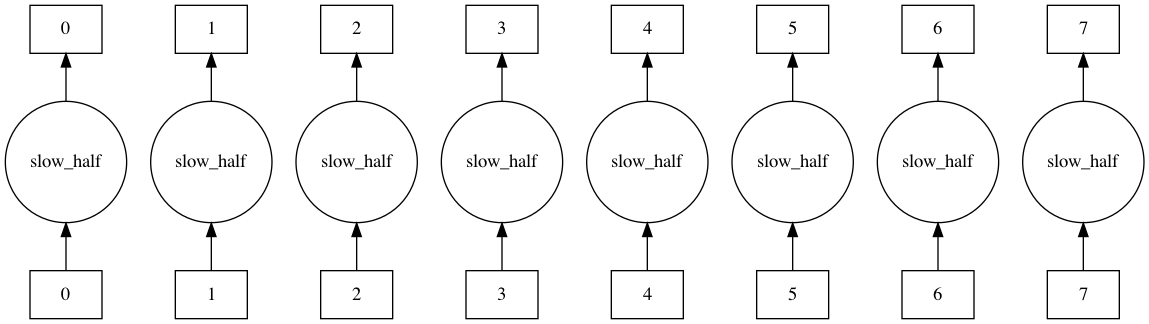

In [7]:
res.visualize()

In [8]:
b.topk

<bound method Bag.topk of dask.bag<from_sequence, npartitions=8>>

In [9]:
b.product(b).compute() # Cartesian product of each pair 
# of elements in two sequences (or the same sequence in this case)

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8)]

Chain operations to construct more complex computations

In [10]:
(b.filter(lambda x: x % 2 > 0)
  .product(b)
  .filter( lambda v : v[0] % v[1] == 0 and v[0] != v[1])
  .compute())

[(3, 1), (5, 1), (7, 1)]

## Daily stock example

Let's use the bag interface to read the json files containing time series.

Each line is a JSON encoded dictionary with the following keys
- timestamp: Day.
- close: Stock value at the end of the day.
- high: Highest value.
- low: Lowest value.
- open: Opening price.

In [11]:
# preparing data
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','data') # this function call will extract json files

In [12]:
%ls data/daily-stock/*.json

data/daily-stock/aet.json   data/daily-stock/hpq.json
data/daily-stock/afl.json   data/daily-stock/ibm.json
data/daily-stock/aig.json   data/daily-stock/jbl.json
data/daily-stock/al.json    data/daily-stock/jpm.json
data/daily-stock/amgn.json  data/daily-stock/luv.json
data/daily-stock/avy.json   data/daily-stock/met.json
data/daily-stock/b.json     data/daily-stock/pcg.json
data/daily-stock/bwa.json   data/daily-stock/tgt.json
data/daily-stock/ge.json    data/daily-stock/usb.json
data/daily-stock/hal.json   data/daily-stock/xom.json
data/daily-stock/hp.json


In [13]:
import dask.bag as db
import json
stocks = db.read_text('data/daily-stock/*.json')

In [14]:
stocks.npartitions

22

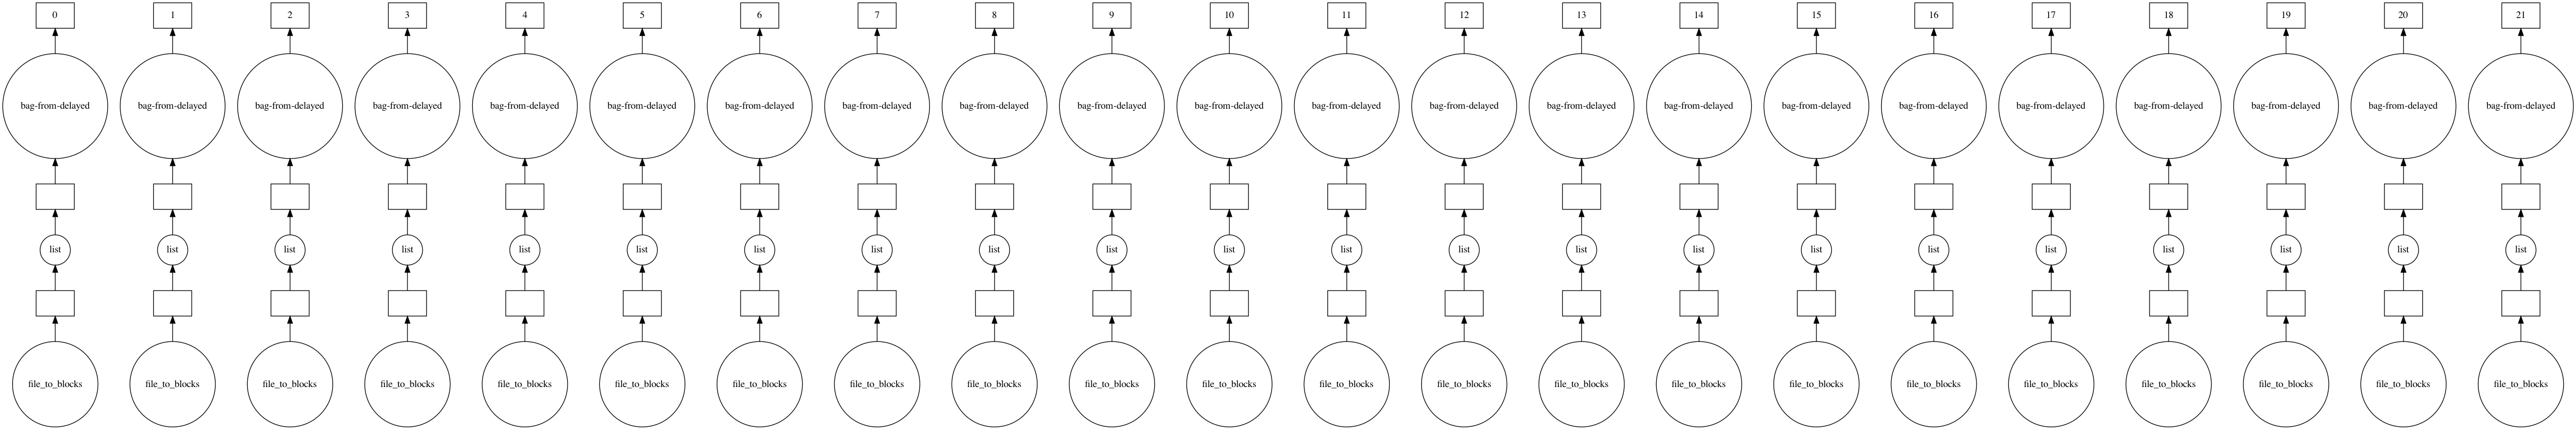

In [15]:
stocks.visualize()

In [16]:
import json
js = stocks.map(json.loads)

In [17]:
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.json')))
filenames

['/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/aet.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/afl.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/aig.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/al.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/amgn.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/avy.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/b.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/bwa.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/ge.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/hal.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/hp.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/hpq.json',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/

In [18]:
%rm data/daily-stock/*.h5

In [19]:
from tqdm.notebook import tqdm
for fn in tqdm(filenames):
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')

In [20]:
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.h5')))
filenames

['/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/aet.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/afl.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/aig.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/al.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/amgn.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/avy.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/b.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/bwa.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/ge.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/hal.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/hp.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/hpq.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/ibm.h5',
 '/

### Serial version

In [21]:
%%time
series = {}
for fn in filenames:   # Simple map over filenames
    series[fn] = pd.read_hdf(fn)['close']

results = {}

for a in filenames:    # Doubly nested loop over the same collection
    for b in filenames:  
        if a != b:     # Filter out bad elements
            results[a, b] = series[a].corr(series[b])  # Apply function

((a, b), corr) = max(results.items(), key=lambda kv: kv[1])  # Reduction

CPU times: user 752 ms, sys: 80.6 ms, total: 832 ms
Wall time: 892 ms


In [22]:
a, b, corr

('/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/aet.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/luv.h5',
 0.9413176064560879)

## Dask.bag methods

We can construct most of the above computation with the following dask.bag methods:

*  `collection.map(function)`: apply function to each element in collection
*  `collection.product(collection)`: Create new collection with every pair of inputs
*  `collection.filter(predicate)`: Keep only elements of colleciton that match the predicate function
*  `collection.max()`: Compute maximum element


In [23]:
%%time

import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series)
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1])).max())

CPU times: user 4.05 ms, sys: 8.34 ms, total: 12.4 ms
Wall time: 12.3 ms


In [24]:
%%time

result = corr.compute()

CPU times: user 2.39 s, sys: 2.3 s, total: 4.69 s
Wall time: 7.68 s


In [25]:
result

0.9413176064560879

### Wordcount with Dask bag

In [26]:
import lorem

lorem.text()

'Dolorem magnam sit labore. Consectetur tempora labore etincidunt quaerat quisquam consectetur quisquam. Eius dolorem quisquam etincidunt porro etincidunt non non. Quiquia eius quiquia magnam velit est. Labore quiquia numquam dolorem est porro quiquia quiquia. Amet dolore porro est. Adipisci sit dolor consectetur. Eius dolor etincidunt quisquam dolore. Labore labore tempora adipisci sed labore. Quisquam ut etincidunt porro porro ut amet amet.\n\nEius neque aliquam porro tempora modi. Dolore magnam quaerat adipisci aliquam aliquam quisquam eius. Amet quiquia porro est. Quaerat quiquia etincidunt adipisci. Dolorem labore ipsum sed labore velit.\n\nSed magnam eius dolore. Dolore sit labore velit. Quiquia quisquam dolore velit consectetur adipisci. Est amet sed magnam quiquia ut. Neque aliquam modi quiquia quiquia. Etincidunt dolor porro quaerat ipsum quisquam. Aliquam non numquam eius etincidunt. Amet quaerat amet amet. Etincidunt aliquam ipsum non.\n\nNumquam modi dolor non est adipisci 

In [27]:
import lorem

for i in range(20):
    with open(f"sample{i:02d}.txt","w") as f:
        f.write(lorem.text())

In [28]:
%ls *.txt

sample00.txt  sample04.txt  sample08.txt  sample12.txt  sample16.txt
sample01.txt  sample05.txt  sample09.txt  sample13.txt  sample17.txt
sample02.txt  sample06.txt  sample10.txt  sample14.txt  sample18.txt
sample03.txt  sample07.txt  sample11.txt  sample15.txt  sample19.txt


In [29]:
import glob
glob.glob('sample*.txt')

['sample06.txt',
 'sample12.txt',
 'sample13.txt',
 'sample07.txt',
 'sample11.txt',
 'sample05.txt',
 'sample04.txt',
 'sample10.txt',
 'sample14.txt',
 'sample00.txt',
 'sample01.txt',
 'sample15.txt',
 'sample03.txt',
 'sample17.txt',
 'sample16.txt',
 'sample02.txt',
 'sample18.txt',
 'sample19.txt',
 'sample09.txt',
 'sample08.txt']

In [30]:
import dask.bag as db
import glob
b = db.read_text(glob.glob('sample*.txt'))

wordcount = (b.str.replace(".","")  # remove dots
             .str.lower()           # lower text
             .str.strip()           # remove \n and trailing spaces
             .str.split()           # split into words
             .flatten()             # chain all words lists
             .frequencies()         # compute occurences
             .topk(10, lambda x: x[1])) # sort and return top 10 words


wordcount.compute() # Run all tasks and return result

[('consectetur', 179),
 ('quisquam', 165),
 ('magnam', 158),
 ('dolorem', 157),
 ('velit', 156),
 ('sit', 155),
 ('aliquam', 155),
 ('dolore', 155),
 ('numquam', 154),
 ('sed', 153)]

## Genome example
We will use a Dask bag to calculate the frequencies of sequences of five bases, and then sort the sequences into descending order ranked by their frequency.

- First we will define some functions to split the bases into sequences of a certain size

### Exercise 9.1

- Implement a function `group_characters(line, n=5)` to group `n` characters together and return a iterator. `line` is a text line in genome.txt file.

```py
>>> line = "abcdefghijklmno"
>>> for seq in group_character(line, 5):
        print(seq)
        
"abcde"
"efghi"
"klmno"
```

    
- Implement `group_and_split(line)`
```py
>>> group_and_split('abcdefghijklmno')
['abcde', 'fghij', 'klmno']
```

- Use the dask bag to compute  the frequencies of sequences of five bases.

In [50]:
line = "abcdefghijklmno"
for seq in group_character(line, 5):
    print(seq)

abcde
fghij
klmno


In [53]:
import os
from glob import glob

data_path = os.path.join("data")
with open(os.path.join(data_path,"genome.txt")) as g:
    data = g.read()
    for i in range(8):
        file = os.path.join(data_path,f"genome{i:02d}.txt")
        with open(file,"w") as f:
            f.write(data)

glob("data/genome0*.txt")

['data/genome01.txt',
 'data/genome00.txt',
 'data/genome02.txt',
 'data/genome03.txt',
 'data/genome07.txt',
 'data/genome06.txt',
 'data/genome04.txt',
 'data/genome05.txt']

### Exercise 9.2

The [FASTA](http://www.cbs.dtu.dk/services/NetGene2/fasta.php) file format is used to write several genome sequences.

- Create a function that can read a [FASTA file](../data/nucleotide-sample.txt) and compute the frequencies for n = 5 of a given sequence.

### Exercise 9.3

Write a program that uses the function implemented above to read several FASTA files stored in a Dask bag.

## Some remarks about bag

*  Higher level dask collections include functions for common patterns
*  Move data to collection, construct lazy computation, trigger at the end
*  Use Dask.bag (`product + map`) to handle nested for loop

Bags have the following known limitations

1.  Bag operations tend to be slower than array/dataframe computations in the
    same way that Python tends to be slower than NumPy/Pandas
2.  ``Bag.groupby`` is slow.  You should try to use ``Bag.foldby`` if possible.
    
3. Check the [API](http://dask.pydata.org/en/latest/bag-api.html) 

4. `dask.dataframe` can be faster than `dask.bag`.  But sometimes it is easier to load and clean messy data with a bag. We will see later how to transform a bag into a `dask.dataframe` with the [to_dataframe](http://dask.pydata.org/en/latest/bag-api.html#dask.bag.Bag.to_dataframe) method.